In [14]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
from torchvision import datasets, transforms

In [15]:
fashion_train=datasets.FashionMNIST(root="FashionMNIST_data",
                                   train=True,
                                   transform=transforms.ToTensor(),
                                   download=True)
fashion_test=datasets.FashionMNIST(root="FashionMNIST_data",
                                   train=False,
                                   transform=transforms.ToTensor(),
                                   download=True)

In [16]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [17]:
def plot(x,y):
    plt.figure(figsize=(8,10))
    for i in range(len(x)):
        plt.subplot(10,10,i+1)
        plt.title(y[i].item())
        img=np.array(x[i]).reshape(28,28)
        plt.imshow(img, cmap='gray')
        plt.axis('off')
    plt.show

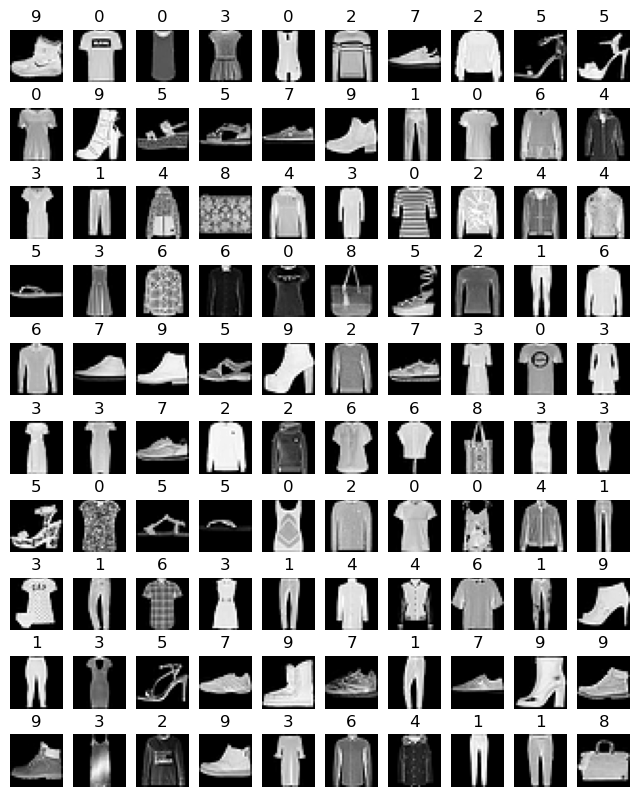

In [18]:
plot(fashion_train.data[:100], fashion_train.targets[:100])

In [22]:
x=fashion_train.data.float()/255 #0~1사이의 값에서 정규화
y=fashion_train.targets
x=x.view(x.size(0), -1) # 이차원 이미지 1차원으로 변경
print(x.size())
print(y.size())
input_size=x.size(-1) # 입력데이터 크기
output_size=int(max(y))+1 # 출력 클래스
print(input_size, output_size)

torch.Size([60000, 784])
torch.Size([60000])
784 10


In [23]:
# Train/Valid 분리
ratio=[0.8, 0.2]

train_cnt=int(x.size(0)*ratio[0])
valid_cnt=int(x.size(0)*ratio[1])
test_cnt=len(fashion_test.data)
print(train_cnt, valid_cnt, test_cnt)
cnts=[train_cnt, valid_cnt]

indices=torch.randperm(x.size(0))
x=torch.index_select(x, dim=0, index=indices)
y=torch.index_select(y, dim=0, index=indices)

x1=list(x.split(cnts, dim=0))
y1=list(y.split(cnts, dim=0))
print(x1[0].shape, x1[1].shape, y1[0].shape, y1[1].shape)

x1+=[(fashion_test.data.float()/255).view(test_cnt, -1)]
y1+=[fashion_test.targets]

#a=[1,2,3]
#b=[10,20,30]
#[(1,10),(2,30),(3,30)]
for x_i, y_i in zip(x1, y1): #[(x1[0],y1[0]),(x1[1],y1[1]),(x1[2],y1[2])
    print(x_i.size())

48000 12000 10000
torch.Size([48000, 784]) torch.Size([12000, 784]) torch.Size([48000]) torch.Size([12000])
torch.Size([48000, 784])
torch.Size([12000, 784])
torch.Size([10000, 784])


In [24]:
model=nn.Sequential(
    nn.Linear(input_size, 500),
    nn.LeakyReLU(),
    nn.Linear(500, 400),
    nn.LeakyReLU(),
    nn.Linear(400, 300),
    nn.LeakyReLU(),
    nn.Linear(300, 200),
    nn.LeakyReLU(),
    nn.Linear(200, 100),
    nn.LeakyReLU(),
    nn.Linear(100, 50),
    nn.LeakyReLU(),
    nn.Linear(50, output_size),
    nn.LogSoftmax(dim=-1)
)

In [26]:
crit=nn.NLLLoss()
optimizer=optim.Adam(model.parameters())

In [27]:
device=torch.device('cpu')
if torch.cuda.is_available():
    device=torch.device('cuda')

In [28]:
model=model.to(device)
x2=[x_i.to(device) for x_i in x1]
y2=[y_i.to(device) for y_i in y1]

In [29]:
epochs=1000
batch_size=256
print_interval=10

In [30]:
from copy import deepcopy
lowest_loss=np.inf # 최소 비용함수값 저장
best_model=None

early_stop=50  # 
lowest_epoch=np.inf # 최소 비용함수값을 가지는 epoch

In [31]:
train_history, valid_history=[],[]

for i in range(epochs):
    indices=torch.randperm(x2[0].size(0)).to(device)
    x_=torch.index_select(x2[0], dim=0, index=indices)
    y_=torch.index_select(y2[0], dim=0, index=indices)

    x_=x_.split(batch_size, dim=0) # list size 48000/256
    y_=y_.split(batch_size, dim=0)

    train_loss, valid_loss=0,0
    y_hat=[]

    for x_i, y_i in zip(x_, y_):
        y_hat_i=model(x_i)
        loss=crit(y_hat_i, y_i.squeeze())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss+=float(loss)
    train_loss=train_loss/len(x_)  #len(x_)=4800/256

    with torch.no_grad():
        x_=x2[1].split(batch_size, dim=0)
        y_=y2[1].split(batch_size, dim=0)
        valid_loss=0

        for x_i, y_i in zip(x_, y_):
            y_hat_i=model(x_i)
            loss=crit(y_hat_i, y_i.squeeze())
            valid_loss +=float(loss)

            y_hat+=[y_hat_i]
    valid_loss= valid_loss/len(x_)

    train_history +=[train_loss]  
    valid_history +=[valid_loss]

    if (i+1) % print_interval==0:
        print(i, train_loss, valid_loss, lowest_loss)

    if valid_loss <= lowest_loss:
        lowest_loss=valid_loss
        lowest_epoch=i

        best_model=deepcopy(model.state_dict())
    
    else:
        if early_stop > 0 and lowest_epoch+early_stop < i+1:
            print('%d이후 %d epoch 증가하는 동안 손실함수 감소가 없음'%(lowest_epoch, early_stop))
            break
        
print('epoch %d일때 손실함수 %.4f가 검증데이터로 가장 낮은 손실함수을 가짐'%(lowest_epoch+1, lowest_loss))    

9 0.263646745856138 0.3032424082147314 0.31337244523332475
19 0.18434785873173398 0.3275761902332306 0.3007690300966831
29 0.13587634055379857 0.3551984793962316 0.3007690300966831
39 0.1056753501216782 0.41015372346056267 0.3007690300966831
49 0.0815602281487527 0.45727369125853196 0.3007690300966831
59 0.057093138380491355 0.5410615091628217 0.3007690300966831
18이후 50 epoch 증가하는 동안 손실함수 감소가 없음
epoch 19일때 손실함수 0.3008가 검증데이터로 가장 낮은 손실함수을 가짐


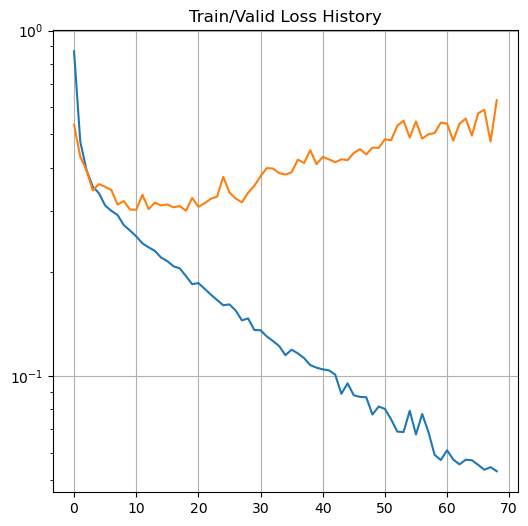

In [32]:
plot_from=0
plt.figure(figsize=(6,6))
plt.grid(True)
plt.title("Train/Valid Loss History")
plt.plot(range(plot_from, len(train_history)), train_history[plot_from:],
         range(plot_from, len(valid_history)), valid_history[plot_from:])
plt.yscale('log')
plt.show()

In [33]:
test_loss=0
y_hat=[]

with torch.no_grad():
    x_=x2[-1].split(batch_size, dim=0) # 10000/256
    y_=y2[-1].split(batch_size, dim=0)

    for x_i, y_i in zip(x_, y_):
        y_hat_i=model(x_i)
        loss=crit(y_hat_i, y_i.squeeze())

        test_loss+=loss
        y_hat+=[y_hat_i]

test_loss=test_loss/len(x_)
y_hat=torch.cat(y_hat, dim=0)

print('test loss:', test_loss)

test loss: tensor(0.7008)


In [34]:
correct_cnt=(y2[-1].squeeze()==torch.argmax(y_hat, dim=-1)).sum()
total_count=float(y2[-1].size(0))
print('accuracy:',(correct_cnt/total_count).item())

accuracy: 0.8902000188827515


In [35]:
import pandas as pd
from sklearn.metrics import confusion_matrix

pd.DataFrame(confusion_matrix(y2[-1], torch.argmax(y_hat, dim=-1)),
             index=['true_%d'%i for i in range(10)],
             columns=['pred_%d'%i for i in range(10)])

,pred_0,pred_1,pred_2,pred_3,pred_4,pred_5,pred_6,pred_7,pred_8,pred_9
true_0,784,2,15,31,2,1,161,0,4,0
true_1,2,978,3,14,1,0,2,0,0,0
true_2,15,1,869,10,49,0,55,0,1,0
true_3,13,7,11,925,20,0,20,0,4,0
true_4,1,1,134,37,757,0,69,0,1,0
true_5,0,0,0,0,0,971,0,21,0,8
true_6,75,1,108,44,38,0,729,0,5,0
true_7,0,0,0,0,0,13,0,972,1,14
true_8,5,0,2,7,0,0,5,3,977,1
true_9,0,0,0,1,0,12,2,45,0,940


In [36]:
pred=model((x2[2][0]).view(-1,784))
print(torch.argmax(pred,-1))
print(y2[-1][0])

tensor([9])
tensor(9)
